C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Low-performing classes based on F1-score: ['Guava__Rotten', 'Jujube__Rotten']
Found 15 misclassified samples in the low-performing classes.


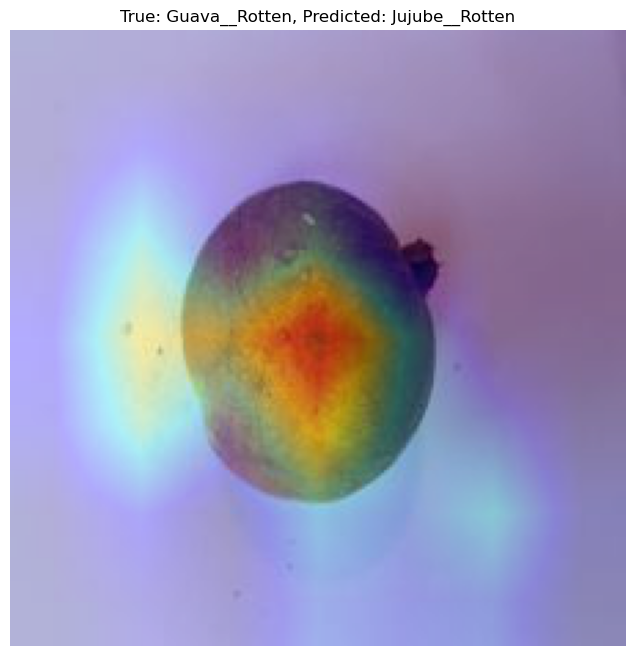

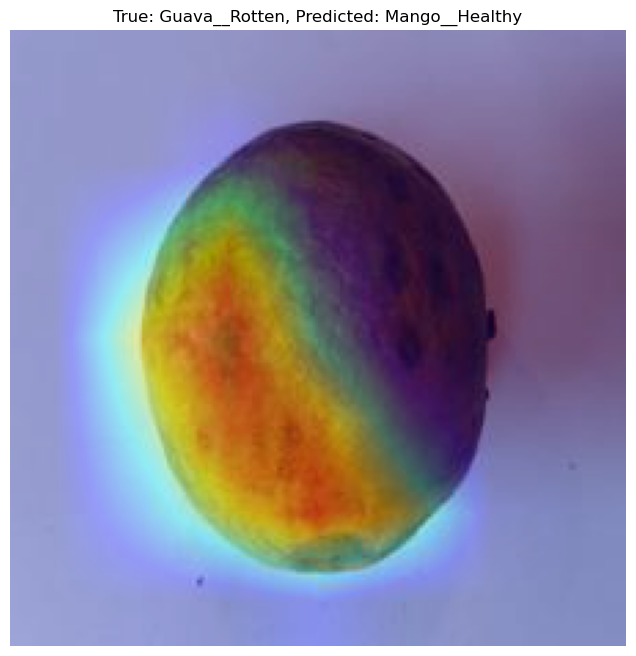

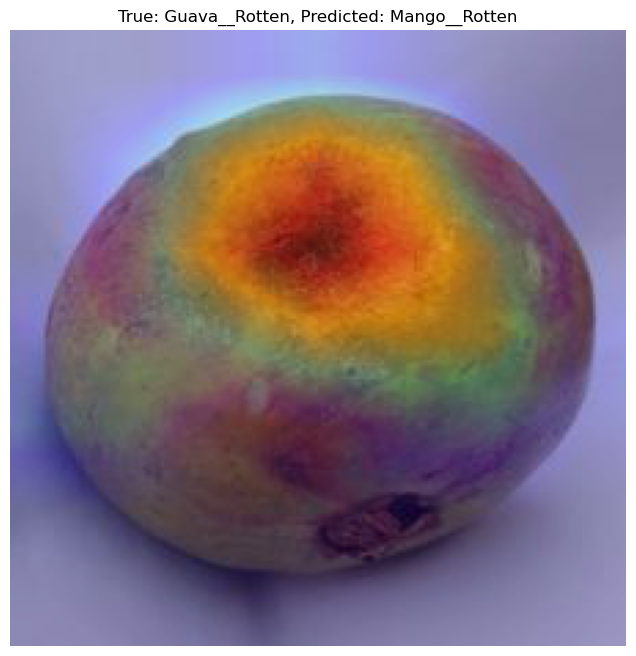

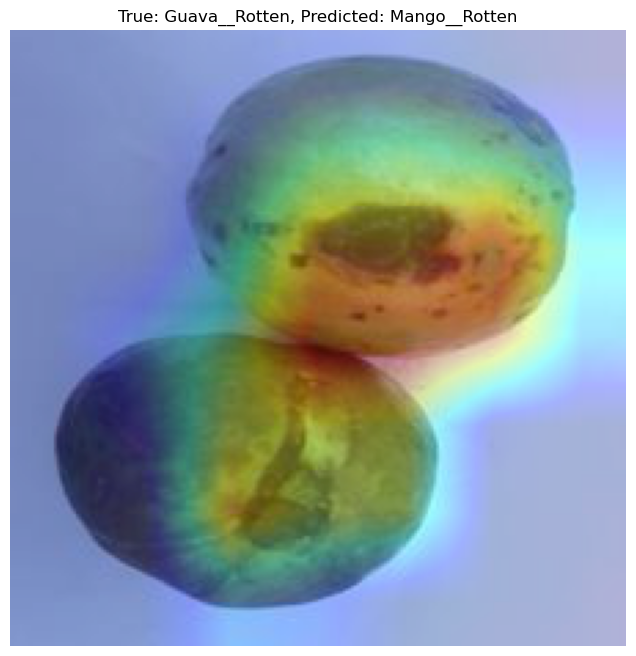

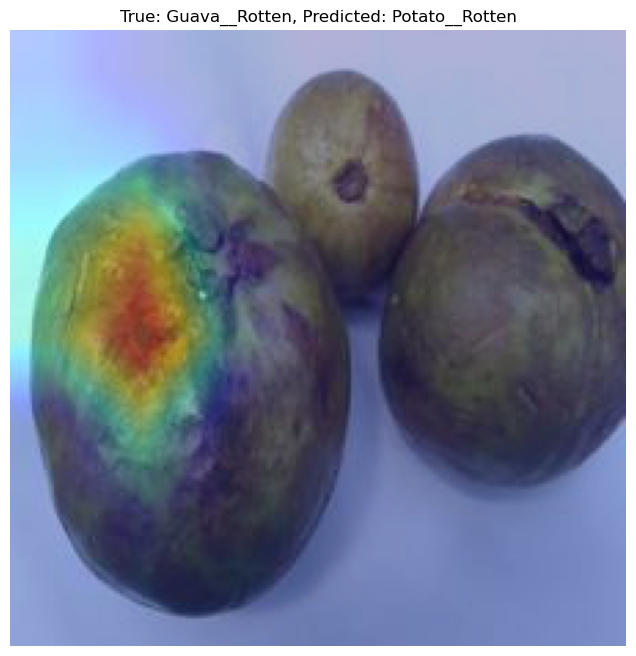

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
from sklearn.metrics import classification_report

# Define data directory and transformations (same as before)
data_dir = "data/processed/"
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load the test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size of 1 for Grad-CAM
class_names = test_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model (architecture needs to be defined again)
model_path = 'model/best_resnet_model.pth'
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Function to get predictions and true labels for the entire test set
def get_all_predictions(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    return y_true, y_pred, np.array(all_outputs)

# Get all predictions and true labels
y_true, y_pred, all_outputs = get_all_predictions(model, test_loader, device)

# Get the classification report to identify low-performing classes
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Identify classes with the lowest F1-scores (e.g., top 2-3)
sorted_classes = sorted(report.items(), key=lambda item: item[1]['f1-score'] if isinstance(item[1], dict) else -1)
low_performing_classes = [item[0] for item in sorted_classes[:3] if isinstance(item[1], dict)] # Get top 3

print(f"Low-performing classes based on F1-score: {low_performing_classes}")

# Find some misclassified images for these low-performing classes
misclassified_samples = []
for idx, (true_label, predicted_label) in enumerate(zip(y_true, y_pred)):
    if true_label != predicted_label and class_names[true_label] in low_performing_classes:
        misclassified_samples.append(idx)

print(f"Found {len(misclassified_samples)} misclassified samples in the low-performing classes.")

# Perform Grad-CAM on a few misclassified images
num_gradcam_examples = min(5, len(misclassified_samples)) # Analyze up to 5 images
target_layers = [model.layer4[-1]] # Choose the last convolutional layer of the last block

for i in range(num_gradcam_examples):
    sample_index = misclassified_samples[i]
    img_tensor, true_label_idx = test_dataset[sample_index]
    true_label = class_names[true_label_idx]
    predicted_label_idx = y_pred[sample_index]
    predicted_label = class_names[predicted_label_idx]

    # Convert tensor to PIL Image for visualization with Grad-CAM
    img_pil = transforms.ToPILImage()(img_tensor / 2 + 0.5).convert("RGB")
    img_np = np.array(img_pil)

    # Reshape the input tensor to (1, C, H, W) for the model
    input_tensor = img_tensor.unsqueeze(0).to(device)

     # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Create the target for Grad-CAM (the predicted class)
    targets = [ClassifierOutputTarget(predicted_label_idx)] # Use ClassifierOutputTarget

    # Get the Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(img_np / 255.0, grayscale_cam, use_rgb=True, image_weight=0.7)

    # Display the results
    plt.figure(figsize=(8, 8))
    plt.imshow(visualization)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

